## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential issues 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set. 
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv('/Users/AnirbanGuha/Library/CloudStorage/OneDrive-Personal/Maven Analytics Courses/Data Science in Python - Regression/Course Materials/Data/sf_clean.csv')

rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


#### 1. EDA

### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA

1. Based on the range of prices below, we may need to subset our data based on some value to predict more "realistic" apartments. Possibly subset based on square-footage.

2. The 'hood_district' feature was read in as an integer but is really a categorical feature. Let's fix that.


In [3]:
rentals_df["hood_district"] = rentals_df["hood_district"].astype("object") 

In [4]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


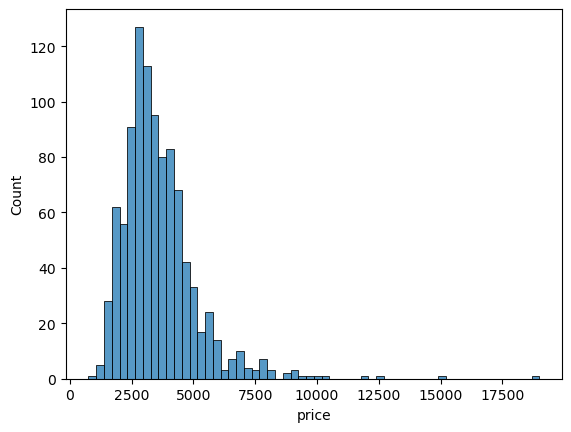

In [6]:
sns.histplot(rentals_df, x="price");

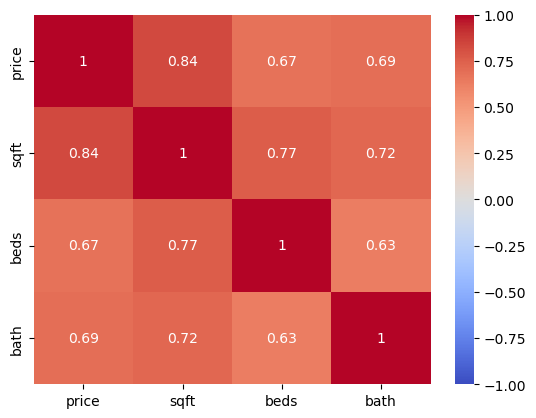

In [7]:
sns.heatmap(
    rentals_df.corr(numeric_only=True), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=True
);

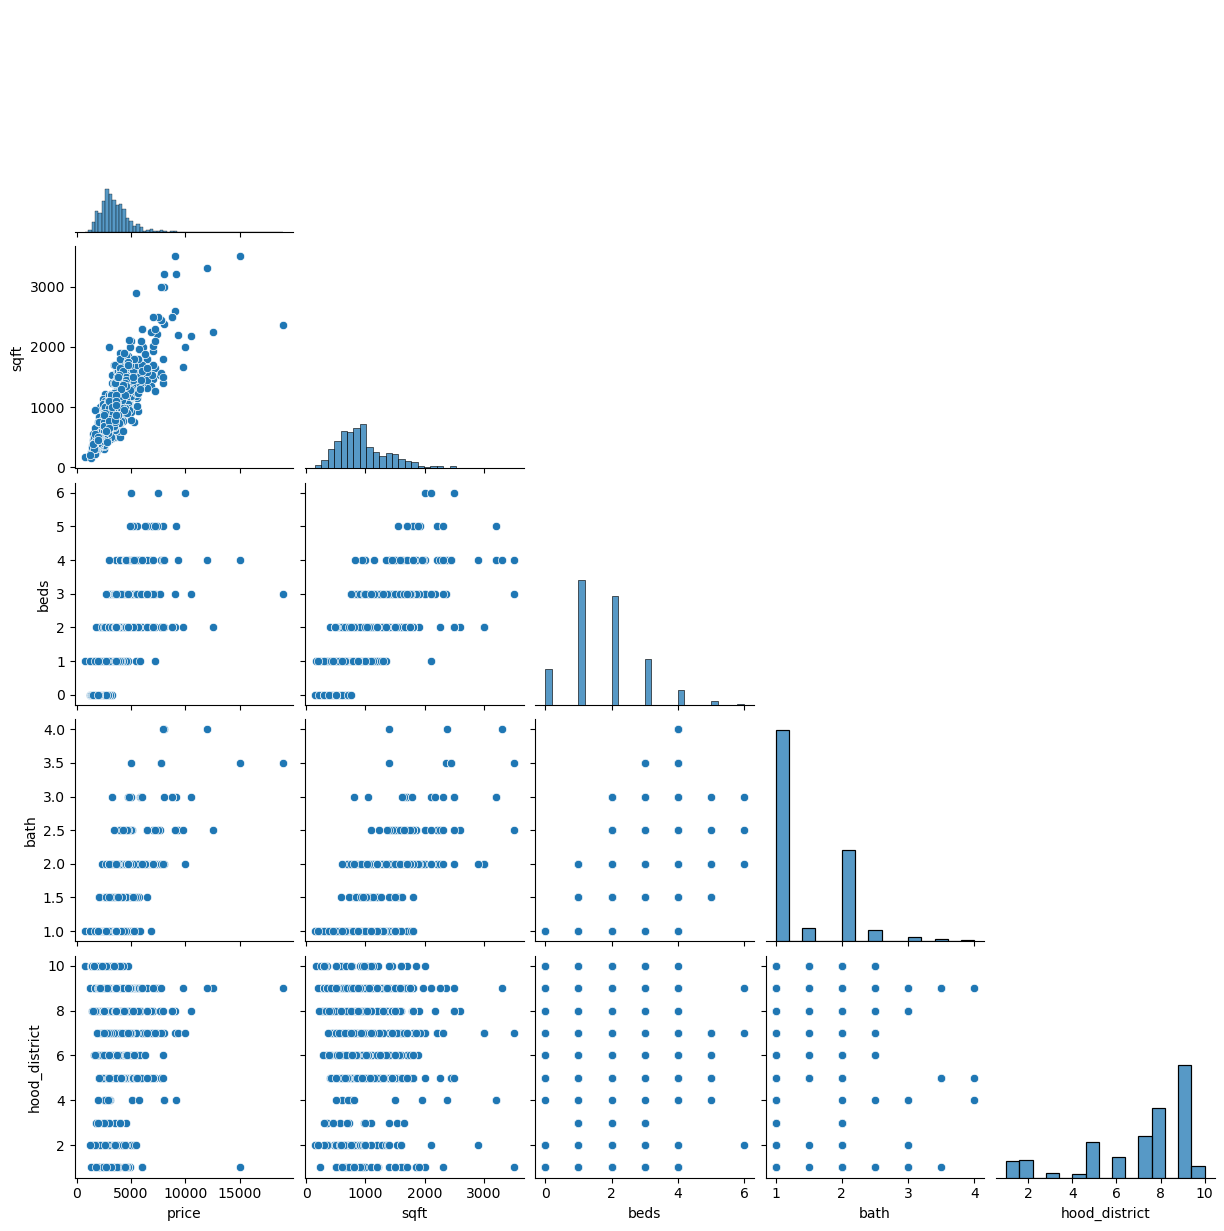

In [8]:
sns.pairplot(rentals_df,corner=True);

# Feature Engineering

1. Group Categories together
2. Trying a Squared Term for Bedrooms, sqft, and bath

In [9]:
laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}


housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"
    
}

In [10]:
eng_df = rentals_df.assign(
#     hood_district = rentals_df["hood_district"].map(district_map),
#     housing_type = rentals_df["housing_type"].map(housing_type_map),
#     pets = rentals_df["pets"].map(pet_map),
#     laundry = rentals_df["laundry"].map(laundry_map),
    sqft2 = rentals_df["sqft"] ** 2,
    sqft3 = rentals_df["sqft"] ** 3,
    beds2 = rentals_df["beds"] ** 2,
    beds3 = rentals_df["beds"] ** 3,
    bath2 = rentals_df["bath"] ** 2,
    bath3 = rentals_df["bath"] ** 3,
    beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"]
)

eng_df = pd.get_dummies(eng_df, drop_first=True, dtype="int")

In [11]:
eng_df.head()

,price,sqft,beds,bath,sqft2,sqft3,beds2,beds3,bath2,bath3,...,parking_(d) no parking,hood_district_2.0,hood_district_3.0,hood_district_4.0,hood_district_5.0,hood_district_6.0,hood_district_7.0,hood_district_8.0,hood_district_9.0,hood_district_10.0
0,6800,1600.0,2.0,2.0,2560000.0,4.096000e+09,4.0,8.0,4.00,8.000,...,0,0,0,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,302500.0,1.663750e+08,1.0,1.0,1.00,1.000,...,0,0,0,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,1690000.0,2.197000e+09,4.0,8.0,1.00,1.000,...,1,0,0,0,0,0,1,0,0,0
3,9000,3500.0,3.0,2.5,12250000.0,4.287500e+10,9.0,27.0,6.25,15.625,...,0,0,0,0,0,0,1,0,0,0
4,3100,561.0,1.0,1.0,314721.0,1.765585e+08,1.0,1.0,1.00,1.000,...,1,0,0,0,0,0,1,0,0,0


#### 2. Modeling

In [12]:
from sklearn.model_selection import train_test_split

target = "price"
drop_cols = [
#     "pets_no_dogs",
#     "housing_type_single"
]

X = sm.add_constant(eng_df.drop([target] + drop_cols, axis=1))

# Log transform slightly improves normality
y = np.log(eng_df[target])
# y = eng_df[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

#### 2.1. Scaling/ Standardizing Data

In [13]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

#### 2.2 Ridge Modelling

In [14]:
from sklearn.linear_model import RidgeCV

n_alphas = 100
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_tr, y)
print(f"Cross Val R2: {ridge_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(ridge_model.predict(X_tr)))}")
print(f"Alpha: {ridge_model.alpha_}")

Cross Val R2: 0.838593191451734
Cross Val MAE: 449.78809785101015
Alpha: 0.13219411484660287


In [17]:
pd.DataFrame({"features":X.columns,"coef_ridge":ridge_model.coef_,})

,features,coef_ridge
0,const,0.000000
1,sqft,0.427719
2,beds,0.082153
3,bath,0.093715
4,sqft2,-0.331123
5,sqft3,0.113359
6,beds2,-0.165434
7,beds3,0.091820
8,bath2,-0.065379
9,bath3,0.058337


#### 2.3 Lasso Modelling

In [18]:
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = 10 ** np.linspace(-2, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_tr, y)

print(f"Cross Val R2: {lasso_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(lasso_model.predict(X_tr)))}")
print(f"Alpha: {lasso_model.alpha_}")

Cross Val R2: 0.8129780229340179
Cross Val MAE: 490.47394723593777
Alpha: 0.01


In [19]:
pd.DataFrame({"features":X.columns,"coef_ridge":ridge_model.coef_,
             "coef_lasso":lasso_model.coef_})

,features,coef_ridge,coef_lasso
0,const,0.000000,0.000000
1,sqft,0.427719,0.204099
2,beds,0.082153,0.000000
3,bath,0.093715,0.082656
4,sqft2,-0.331123,-0.000000
5,sqft3,0.113359,-0.006974
6,beds2,-0.165434,-0.000000
7,beds3,0.091820,-0.000000
8,bath2,-0.065379,0.000000
9,bath3,0.058337,0.000000


In [20]:
print(mae(np.exp(y_test), np.exp(lasso_model.predict(X_te))))
print(f"Test R2: {r2(y_test, lasso_model.predict(X_te))}")

429.3308640276253
Test R2: 0.7991516425617744


#### 2.4 Elastic Net Modelling

In [21]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-2, 3, 200)
l1_ratios = np.linspace(.01, 1, 100)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

enet_model.fit(X_tr, y)

print(f"Cross Val R2: {enet_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(enet_model.predict(X_tr)))}")
print(f"Alpha: {enet_model.alpha_}")
print(f"L1_Ratio: {enet_model.l1_ratio_}")

Cross Val R2: 0.8346175733621186
Cross Val MAE: 457.36513834175764
Alpha: 0.01
L1_Ratio: 0.01


In [22]:
pd.DataFrame({"features":X.columns,"coef_ridge":ridge_model.coef_,
             "coef_lasso":lasso_model.coef_,
             "elastic_net_coef":enet_model.coef_})

,features,coef_ridge,coef_lasso,elastic_net_coef
0,const,0.000000,0.000000,0.000000
1,sqft,0.427719,0.204099,0.239555
2,beds,0.082153,0.000000,0.050527
3,bath,0.093715,0.082656,0.051443
4,sqft2,-0.331123,-0.000000,-0.002857
5,sqft3,0.113359,-0.006974,-0.048581
6,beds2,-0.165434,-0.000000,-0.066637
7,beds3,0.091820,-0.000000,0.017092
8,bath2,-0.065379,0.000000,0.023691
9,bath3,0.058337,0.000000,0.011789


#### 2.5 Final Test Modelling

In [23]:
print(f"Test MAE: {mae(np.exp(y_test), np.exp(ridge_model.predict(X_te)))}")
print(f"Test R2: {r2(y_test, ridge_model.predict(X_te))}")

Test MAE: 422.2406817202934
Test R2: 0.7988883883318407
